# Relativistic Raytracer
*PC6432 Project*

or, a guide in three days of procrastination and a 30% grade deduction

*brought to you by @chas-card, @owl10124, and @TheRealOrange*


In [ ]:
from array import array
from PIL import Image
from stl import mesh
import numpy as np
import math


np_type = np.float32
c = 8 #3e8

FARAWAY = 1.0e+39  # A large distance (i cant forsee how this will go wrong)

In [ ]:
def norm(arr): return arr/np.sqrt(np.sum(np.square(arr),axis=0))
def lt_velo(lt, velo):
    if len(np.shape(velo))==1: velo=velo[:,np.newaxis]
    v4 = np.concatenate((np.array([c*np.ones(np.shape(velo)[1])]), velo), axis=0)
    vp4 = lt @ v4
    return vp4[1:]*c/vp4[0]

# Background
Special Relativity is understood to produce effects including length contraction or time dilation, however problems about these effects tend to focus on 1 dimensional lengths.

Instead, to more intuitively grasp these effects, let’s visualise these from 3D objects.

Ultimately these are commonly asked questions with various past works exploring specific aspects of relativity.
## References
[Report by an MIT computer graphics team on Visualising Fast Objects](https://groups.csail.mit.edu/graphics/classes/6.837/F97/projects/reports/team19.pdf)
MIT team did a short exploration into visualising very fast objects, 
modifying existing ray tracing libraries to account for Lorentz transforms of rays and doppler shift of resulting colors, 
making a few observations like how objects have apparent “stretch” and rotate (Terrell rotation)

[spacetimetravel.org](https://spacetimetravel.org)
An entire site dedicated to exploring visualisations of theory of relativity, simulating phenomena to demonstrate effects. 


# Visualising our objects - Rendering by ray tracing
To “see” our objects, we need some way of peering into our 3D world and drawing an image.
Thankfully this is also a common problem and many algorithms exist,
we draw from [*James Bowman’s implementation*](https://excamera.com/sphinx/article-ray.html) of a ray tracing algorithm in python for how our raytracer logic will work
[*https://excamera.com/sphinx/article-ray.html*](https://excamera.com/sphinx/article-ray.html)

![image](references/coord_frames.png)
*Existing library only has spheres and limited in scope, we mainly reference for logic
*also a note for coordinate system*

**Other references we used**
[Medium article on ray tracing python from scratch](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)
also used as reference for explanation

[ScratchAPixel](https://www.scratchapixel.com/)
Resource on computer graphics basics

**Ray tracing** mimics how light from sources bounce off objects an land onto a camera to produce an image.

However, instead of actually simulating vast amounts of rays of light from a light source, only to filter the few rays which reach the camera.
We apply the reverse, projecting rays from the camera and simulating where those rays reach.
If a ray “hits” an object, then part of the “light” reflects perfectly while the rest diffuses, some rays might travel straight at the light source, hence those pixels will be very bright, while some may never intersect anything and have black background colour, and so on.
![image](references/1_unARAf_8oLsXAQVp3obY0Q.jpeg)
*from Medium article*

This way of tracing a ray’s path from the camera to a source is a common rendering technique called the ray casting algorithm
Of course, this simple definition would treat all objects as perfect mirrors, and only rays which reflect perfectly to a light source would be bright. For more realistic shading and simulating diffuse lighting we also implement the Blinn-Phong reflection model.



# Implementation
## Frame

We implement the obvious important concept in SR: the transform between inertial reference frames.

Each frame has a velocity vector, giving rise to its own LT.


### Lorentz Transformation

Since we are dealing with a generalised LT which is capable of transforming reference frames which have relative velocities on more than one axis, the LT is in the form of a 4 by 4 matrix, shown below
$$
{\displaystyle \mathcal{L}(\mathbf {v} )={\begin{bmatrix}\gamma &-\gamma v_{x}/c&-\gamma v_{y}/c&-\gamma v_{z}/c\\-\gamma v_{x}/c&1+(\gamma -1){\dfrac {v_{x}^{2}}{v^{2}}}&(\gamma -1){\dfrac {v_{x}v_{y}}{v^{2}}}&(\gamma -1){\dfrac {v_{x}v_{z}}{v^{2}}}\\-\gamma v_{y}/c&(\gamma -1){\dfrac {v_{y}v_{x}}{v^{2}}}&1+(\gamma -1){\dfrac {v_{y}^{2}}{v^{2}}}&(\gamma -1){\dfrac {v_{y}v_{z}}{v^{2}}}\\-\gamma v_{z}/c&(\gamma -1){\dfrac {v_{z}v_{x}}{v^{2}}}&(\gamma -1){\dfrac {v_{z}v_{y}}{v^{2}}}&1+(\gamma -1){\dfrac {v_{z}^{2}}{v^{2}}}\end{bmatrix}}}
$$

Where $\gamma$ is the Lorentz factor, and $v_x$, $v_y$, $v_z$ are the 3 cartesian coordinate components of the velocity vector, and $v = \sqrt{{v_x}^2 + {v_y}^2 + {v_z}^2}$

### Defining Frames for Computation

We also define each frame relative to another frame. At the 'bottom', or the 'root' of the tree of references is a world frame. All the frames which are defined are either in the 'special' world frame or relative to it, either directly or recursively through another frame. This way, we can transform from any frame to any other frame by first transforming 'up' to the world frame, then transforming 'down' the chain of references to any other frame.

Furthermore, since LTs have the special property where multiplication with another LT also produces an LT, we can use this property to generate a single LT for transforming from one frame to another simply by multiplying all the LTs along the reference chain together.

In [ ]:
# frame class to handle defining different reference frames with respect to other reference frames
# world frame is just (0, 0, 0, 0) position, use it as a "special" frame to transform between any frames
class Frame:
    def __init__(self, velocity, ref=None):
        self.velocity = np.array(velocity, dtype=np_type)
        self.ref = ref

    @property
    def lt(self):
        b=self.velocity/c
        b2 = np.sum(np.square(b))
        assert (b2 <= 1)

        g = 1 / (np.sqrt(1 - b2))

        lt_mat = np.eye(4, dtype=np_type)
        if b2==0: return lt_mat

        lt_mat[0, 0] = g
        lt_mat[0, 1:] = lt_mat[1:, 0] = -b * g
        lt_mat[1:, 1:] += (g - 1) * np.matmul(b[np.newaxis].T, b[np.newaxis]) / b2

        assert(abs(np.linalg.det(lt_mat)-1)<1e-3)
        return lt_mat

    @property
    def inv_lt(self):
        inv_lt_mat = self.lt
        inv_lt_mat[0, 1:] = -inv_lt_mat[0, 1:]
        inv_lt_mat[1:, 0] = -inv_lt_mat[1:, 0]
        return inv_lt_mat

    @property
    def to_world_lt(self):
        if self.ref is None:
            return self.inv_lt
        else:
            return np.matmul(self.ref.to_world_lt, self.inv_lt)

    @property
    def from_world_lt(self):
        if self.ref is None:
            return self.lt
        else:
            return np.matmul(self.lt, self.ref.from_world_lt)

    def compute_lt_to_frame(self, frame):
        return np.matmul(frame.from_world_lt, self.to_world_lt)

    def compute_lt_from_frame(self, frame):
        return np.matmul(self.from_world_lt, frame.to_world_lt)

    def __str__(self):
        return "Frame with velocity "+str(self.velocity)+" wrt "+str(self.ref)

## Raytracing and LTs

Raytracing involves taking a bunch of rays and running, for each object, two functions.
Intersect: calculates your distance to the ray’s source. This tells us if you’re closest to the ray, and thus lets you filter which rays are your problem.

Light: does the actual heavy lifting on determining your rays’ colour. This often involves some fancy operations and shaders:

- Blinn-Phong reflection model: assuming some light will reach light source and treating intersect point as darker if intersect angle is more tangent
- Reflections: reflect the rays about normals, and do another pass of raytracing from there (bounce).

By raytracing all the camera’s rays, you get the image — “easy”.




## Camera

This does exactly what you’d expect: it provides an origin (point) and directions (normalised) for every pixel of the screen. 

(Previously this implemented abstractions for transforming the origin and directions, but these proved quite simple with the nature of LTs.)

In [ ]:
class Camera:
    def __init__(self, time, pos, rotn, dof, frame, bounces):
        self.point = None
        self.w, self.h = (640, 480)
        self.ray_dirs = None
        self.screen_coords = None
        self.time = time
        self.pos = pos
        self.rotn = rotn
        self.dof = dof
        self.frame = frame
        self.bounces = bounces
        self.calc_rays()

    def calc_rays(self):
        x, y, z = self.pos
        self.point = np.array((self.time * c, x, y, z + self.dof), dtype=np_type)

        r = float(self.w) / self.h
        # Screen coordinates: x0, y0, x1, y1.
        S = 10 * np.array((-1, 1 / r, 1, -1 / r))
        x = np.tile(np.linspace(S[0], S[2], self.w), self.h)
        y = np.repeat(np.linspace(S[1], S[3], self.h), self.w)

        sigma, theta = self.rotn
        rotmat = np.array([[1, 0, 0, 0], [0, np.cos(sigma), 0, np.sin(sigma)], [0, 0, 1, 0],
                           [0, -np.sin(sigma), 0, np.cos(sigma)]]) @ np.array(
            [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(theta), np.sin(theta)], [0, 0, -np.sin(theta), np.cos(theta)]])
        self.screen_coords = rotmat @ np.stack((np.full((x.shape[0],), self.time * c), x, y, np.zeros(x.shape[0])),
                                               axis=0) + self.point[:, np.newaxis]
        self.point += rotmat @ np.array([0, 0, 0, -self.dof])

        self.ray_dirs = norm((self.screen_coords - self.point[:, np.newaxis])[1:])

    def set_time(self, t):
        self.time = t
        self.calc_rays()


## But! Special relativity?!

We want to account for the speed of light being finite: the object has moved between the time of light ray capture and emission. Normals and directions may also be scuffed.

To mitigate this: we consider the **reference frame** of the object (assuming constant velocity), in which the object is stationary! It’s still an inertial frame so we can just work in it.

(We assume all frames share an origin: we didn’t want to do that at first, but then realised that there was no clear reversible way to set a ‘shared zero time’, and conversion would be painful.)

### Helper functions

We wrap `intersect` and `light` in helper functions — `intersect_frame` and `light_frame` — which Lorentz-transform the directions / light rays / coordinates / distances **in and out of** the object’s frame.
- (4D) Positions: simply premultiply LT
- Velocities: premultiply LT to (c,vx,vy,vz) to get (cdt’,dx’,dy’,dz’), then divide the last three elements by the first. `4d[1:]/4d[0]`
- Directions (unit vectors): treat the normal vector as a speed of light, because it’s invariant under LTs. I find this quite hilarious.
- Distances (scalars): Convert to positions, transform those, convert back.

Specifically, it’s safe to directly take $b’=|\mathcal L(b\hat x)|$.

### Accounting for time

Time is no longer a constant for each intersection point: indeed, remember we are raytracing backwards through time! 

We account for this in the `light` function itself, which operates on the ray’s intersection point: we note the time position of this intersection, namely **(ray length)/c** subtracted from source time. Again, remember the frame doesn’t matter.

This yields us a 4-dimensional position, which we use for further transforms.

- The effects of time (regarding speed and thus displacement of other objects) are actually **accounted for** by the LT / frame shifts themselves. These affect the position of the ray in other frames.


## Object

One class to rule them all; it carries these four functions.
In general `light_frame` and `intersect_frame` are constant, `light` is material-dependent (geometry-independent) and `intersect` is geometry-dependent.

In [ ]:
class Object:

    def __init__(self, position, frame, diffuse, mirror=0.8):
        """
        Initialize new Object

        :param array position: array of x y z position
        :param Frame frame:
        :param array diffuse: RGB colour (from 0 to 1)
        :param float mirror: how much to reflect
        """
        self.position = np.array(position, dtype=np_type)
        self.frame = frame
        self.diffuse = np.array(diffuse, dtype=np_type)
        self.mirror = mirror

    def intersect_frame(self, source, dirs, frame):
        """

        :param screen:
        :return:
        """
        lt = frame.compute_lt_to_frame(self.frame)
        pt, dirs = lt @ source, lt_velo(lt, dirs*c)/c

        time, pos = pt[0], pt[1:]
        (dists, norms) = self.intersect(pos, dirs)
        
        v4 = np.concatenate(([-dists/c],(dirs*dists)),axis=0)
        return (np.sqrt(np.sum(np.square(((frame.compute_lt_from_frame(self.frame) @ v4)[1:]).T), axis=1)), norms)

    def light_frame(self, source, dirs, dists, norms, frame, scene, bounce):
        """

        :param screen:
        :return:
        """
        lt = frame.compute_lt_to_frame(self.frame)

        pt, dirs = lt @ source, lt_velo(lt, dirs*c)/c
        time, pos = pt[0], pt[1:]
        
        v4 = np.concatenate(([-dists/c],(dirs*dists)),axis=0)
        dists = np.sqrt(np.sum((np.square((lt @ v4)[1:]).T), axis=1))
        
        return self.light(pt, dirs, dists, norms, scene, bounce)

    def diffuseColor(self, M):
        """
        Object colour function

        :param np.ndarray M: intersection point(s)  shape(N,3)
        :return: colour(s)
        """
        return self.diffuse

    def intersect(self, source, direction):
        """
        Ray to Object Intersect function

        :param np.ndarray source: ray source position vector | shape(3, N)
        :param np.ndarray direction: rays direction unit vector | shape(3, N)
        :return: intersection distance for each ray  shape(N,)
        """
        return np.full(direction.shape[1], FARAWAY)		# default return array of FARAWAY (no intersect)

    def light(self, source, dirs, dists, norms, scene, bounce):
        """
        Recursive raytrace function

        :param np.ndarray source: ray source position vector | shape(3, N)
        :param np.ndarray dirs: rays direction unit vector | shape(3, N)
        :param np.ndarray dists: ray intersect distances | shape(N,)
        :param np.ndarray norms: object-frame face normals | shape(N,)
        :param scene: array of Object instances
        :param int bounce: number of bounces
        :return: array of colours for each pixel | shape(N,3)
        """
        time = source[0] - dists/c
        pts = source[1:] + dirs*(dists.T)
        tol = norm(scene.light[:,np.newaxis] - pts)
        toc = norm(scene.camera.point[1:][:,np.newaxis] - pts)
        nudged = pts + norms*.0001    # default return all black

        #return np.array([self.diffuseColor(pts)]*len(dists))

        #n4d = np.concatenate(([time], nudged), axis=0) #TODO
        #distsl = [s.intersect_frame(n4d,tol,self.frame)[0] for s in scene.objs]
        #nearl = np.amin(distsl,axis=0)
        #seelight = distsl[scene.objs.index(self)] >1e30

        color = np.array([[.05]*3]*len(dists))

        lv = np.maximum(np.einsum("ij,ij->j",norms,tol),0)
        #color+=np.outer((lv * seelight),self.diffuseColor(pts))
        color += np.outer(lv, self.diffuseColor(pts))

        # if bounce<scene.camera.bounces:
        #     nray = norm(dirs - 2 * norms * np.einsum("ij,ij->j",dirs,norms))
        #     color += scene.raytrace(n4d, nray, self.frame, bounce+1) * self.mirror

        phong = np.einsum("ij,ij->j",norms, norm(tol+toc))
        color += np.outer((np.power(np.clip(phong, 0, 1), 50)),np.ones(3))
        #color += np.outer((np.power(np.clip(phong, 0, 1), 50) * seelight),np.ones(3))


        return color
        #return np.full(direction.shape[1], self.diffuseColor(None))    # default return all black

    def __str__(self):
        return self.__class__.__name__+" at position "+str(self.position)+" with color "+str(self.diffuse)+" in frame: "+str(self.frame)

### SphereObject
`intersect`: solves a quadratic equation to determine sphere intersection

In [ ]:
class SphereObject(Object):
    def __init__(self, position, frame, diffuse, radius):
        super().__init__(position, frame, diffuse)
        self.radius = radius

    def intersect(self, source, direction): # this is refactored and likely broken btw just check
        b = 2 * np.einsum("ij,ij->j", direction, source - self.position[:,np.newaxis])
        c = np.sum(np.square(self.position)) + np.sum(np.square(source),axis=0) - 2 * np.dot(self.position, source) - (self.radius ** 2)

        disc = np.square(b) - (4 * c)
        sq = np.sqrt(np.maximum(0, disc))
        h0 = (-b - sq) / 2
        h1 = (-b + sq) / 2
        h = np.where((h0 > 0) & (h0 < h1), h0, h1)
        pred = (disc > 0) & (h > 0)
        return (
            np.where(pred, h, FARAWAY), 
            np.where(pred[np.newaxis,:], (source-self.position[:,np.newaxis]+np.einsum("ij,j->ij",direction,h)) / self.radius, np.zeros(np.shape(direction)))
        )


### MeshObject
A direct import from an .stl file, with a numpy-optimised intersection function.

In [ ]:
class MeshObject(Object):
    def __init__(self, position, frame, mesh, diffuse, mirror=0.5):
        super().__init__(position, frame, diffuse, mirror=mirror)
        self.m = mesh
        self.m.translate(position)
        self.chunksize = 50

    def intersect(self, source, direction):
        m = self.m
        meshN = m.get_unit_normals()

        # array of intersect lengths for ALL triangles
        t_overall = np.full(direction.shape[1], FARAWAY)  # initialize to assume all distances are FARAWAY
        N_overall = np.full(direction.shape, 0, dtype=np_type).T

        polygons = meshN.shape[0]
        N = math.ceil(polygons / self.chunksize)

        chunks = [min((i + 1) * self.chunksize, polygons) for i in range(N)]
        meshN_chunks = np.array_split(meshN, chunks, axis=0)
        v0_chunks = np.array_split(m.v0, chunks, axis=0)
        v1_chunks = np.array_split(m.v1, chunks, axis=0)
        v2_chunks = np.array_split(m.v2, chunks, axis=0)

        eijk = np.zeros((3, 3, 3))
        eijk[0, 1, 2] = eijk[1, 2, 0] = eijk[2, 0, 1] = 1
        eijk[0, 2, 1] = eijk[2, 1, 0] = eijk[1, 0, 2] = -1

        done_size = 0
        path1 = None
        path2 = None
        for i in range(N):
            curr_size = meshN_chunks[i].shape[0]
            intersectLens = np.einsum("at,tb->ab", meshN_chunks[i], direction)

            intersectLens = np.where(intersectLens == 0, 1 / FARAWAY, intersectLens)

            t = np.einsum("ab,ab->ab",
                          np.einsum("abt,at->ab", (v0_chunks[i][:, np.newaxis, :] - source.T[np.newaxis, :, :]),
                                    meshN_chunks[i]), np.reciprocal(intersectLens))
            t = np.where(t < 0, FARAWAY, t)

            P = source.T[np.newaxis] + np.einsum("ab,cb->cba", direction, t)

            edge = (v1_chunks[i] - v0_chunks[i])
            vp = P - v0_chunks[i][:, np.newaxis, :]
            if path1 is None:
                path_info = np.einsum_path("ijk,uj,uvk->uvi", eijk, edge, vp, optimize='optimal')
                path1 = path_info[0]
                #print(path_info[1])
            C = np.einsum("ijk,uj,uvk->uvi", eijk, edge, vp, optimize=path1)
            if path2 is None:
                path_info = np.einsum_path("ab,acb->ac", meshN_chunks[i], C, optimize='greedy')
                path2 = path_info[0]
                #print(path_info[1])
            d = np.einsum("ab,acb->ac", meshN_chunks[i], C, optimize=path2)
            t = np.where(d < 0, FARAWAY, t)

            edge = (v2_chunks[i] - v1_chunks[i])
            vp = P - v1_chunks[i][:, np.newaxis, :]
            C = np.einsum("ijk,uj,uvk->uvi", eijk, edge, vp, optimize=path1)
            d = np.einsum("ab,acb->ac", meshN_chunks[i], C, optimize=path2)
            t = np.where(d < 0, FARAWAY, t)

            edge = (v0_chunks[i] - v2_chunks[i])
            vp = P - v2_chunks[i][:, np.newaxis, :]
            C = np.einsum("ijk,uj,uvk->uvi", eijk, edge, vp, optimize=path1)
            d = np.einsum("ab,acb->ac", meshN_chunks[i], C, optimize=path2)
            t = np.where(d < 0, FARAWAY, t)

            min_t = np.min(t, axis=0)
            done_size += curr_size
            min_polygon = (t != FARAWAY) & (t == min_t[np.newaxis, :])
            b = min_polygon[:, :, np.newaxis]
            sel_n = np.sum(b * meshN_chunks[i][:, np.newaxis, :], axis=0)
            N_overall += sel_n
            t_overall = np.where(min_t < t_overall, min_t, t_overall)

        return t_overall, N_overall.T

    def chas_intersect(self, source, direction):
        # TODO: TEST IF WORKS
        # numpy-stl mesh get normal vectors as unit vectors
        m = self.m
        meshN = self.m.get_unit_normals()

        # array of intersect lengths for ALL triangles
        # initialize to assume all distances are FARAWAY
        t_overall = np.full(direction.shape[1], FARAWAY)

        # array of intersect normals for ALL triangles
        N_overall = np.full(direction.shape, 0).T

        direction = direction.T
        for i in range(0, len(m.v0)):
            v1 = m.v0[i]  # point 1
            v2 = m.v1[i]  # point 2
            v3 = m.v2[i]  # point 3
            N = meshN[i]

            # INTERSECT TRIANGLE PLANE =================================
            # compute intersect lengths to plane
            intersectLens = direction.dot(N)
            # Check if ray and plane are parallel
            if intersectLens.all() == 0:
                continue			# no intersects
            # intersect lengths to plane
            t = (v1 - source.T).dot(N) / intersectLens
            # check if triangle behind ray
            t = np.where(t < 0, FARAWAY, t)
            # intersection point(s) (individual vectors) using equation
            P = source.T + direction * t[:,np.newaxis]
            # END INTERSECT TRIANGLE PLANE =============================

            # CHECK INSIDE/OUTSIDE =====================================
            # whether intersect point within triangle area

            edge = v2 - v1  # vector 1-2
            vp = P - v1  # vector 1-P    array of such vectors
            C = np.cross(edge, vp)  # C IS N x 3
            t = np.where(np.dot(C, N) < 0, FARAWAY, t)

            edge = v3 - v2  # vector 2-3
            vp = P - v2  # vector 2-P    array of such vectors
            C = np.cross(edge, vp)  # C IS N x 3
            t = np.where(np.dot(C, N) < 0, FARAWAY, t)

            edge = v1 - v3  # vector 3-1
            vp = P - v3  # vector 3-P    array of such vectors
            C = np.cross(edge, vp)  # C IS N x 3
            t = np.where(np.dot(C, N) < 0, FARAWAY, t)

            # END CHECK INSIDE/OUTSIDE =================================

            # Get closest distances
            t_overall = np.where(t < t_overall, t, t_overall)
            # array of whether t < t_overall
            tLess_bool = t < t_overall

            # Get closest distances
            t_overall = np.where(tLess_bool, t, t_overall)

            # Add normals to N_overall (only if t was closer)
            tLess_bool_broadcast = np.repeat(tLess_bool.reshape((1, len(tLess_bool))), 3, axis=0).T
            N_overall = np.where(tLess_bool_broadcast, N, N_overall)

        return (t_overall, N_overall)

## Scene
Ties this whole mess together by controlling general flow

In [ ]:
class Scene:
    def __init__(self, camera, light, objs):
        self.camera = camera
        self.light = light
        self.objs = objs
    
    def raytrace(self, source, dirs, frame, bounce=0):
        res = [s.intersect_frame(source, dirs, frame) for s in self.objs]
        color = np.zeros((np.shape(source)[1],3))
        if (not res): return color
        dists, norms = zip(*res) # (objects) x (screen dims)
        nearest = np.amin(dists, axis=0)
        for (s, d, n) in zip(self.objs, dists, norms):
            print("Bounce "+str(bounce)+" of "+str(self.camera.bounces)+": Raytracing object "+str(s))
            hit = (nearest < 1e30) & (d == nearest)
            if np.any(hit):
                sourcec = np.compress(hit, source, axis=1)
                distsc = np.compress(hit, d)
                dirsc = np.compress(hit, dirs,axis=1)
                normsc = np.compress(hit, n, axis=1)
                colorc = s.light_frame(sourcec, dirsc, distsc, normsc, frame, self, bounce)
                ret = np.zeros((*hit.shape,3))
                for i in range(3):
                    np.place(ret[:,i],hit,colorc[:,i])
                color+=ret
        return color

    def tracescene(self):
        return self.raytrace(np.array([self.camera.point]*np.shape(self.camera.ray_dirs)[1]).T,self.camera.ray_dirs,self.camera.frame,bounce=0)

    def render(self):
        return Image.merge("RGB", [Image.fromarray((255 * np.clip(c, 0, 1).reshape((self.camera.h, self.camera.w))).astype(np.uint8), "L") for c in self.tracescene().T])

# A Test Render
Each render may take a while... (roughly a minute)

In [ ]:
x,y = 5,3
f0=Frame([0,0,0])

cam = Camera(0,(0,800,-800),(0,-np.pi/6),20,f0,2)

frames = [Frame(np.array((8.0,0,0))*(1-1/(1<<i))) for i in range(y)]
boxes = [MeshObject(np.array(((i-4*j)*300,0,j*300)),frames[j],mesh.Mesh.from_file('models/block100.stl'),np.array((1-1/(1<<j),1,0))) for i in range(-x,x+1) for j in range(y)]
#floor = SphereObject(np.array((0,-90100,0)),f0,np.array((0,0,.5)),90000)

print("scene created")

scene = Scene(cam, np.array((400, 10000, -3000)), boxes)#,floor])
display(scene.render())

# Results
Some proofs of concept and cool renders we liked.

In [3]:
# frame class to handle defining different reference frames with respect to other reference frames
# world frame is just (0, 0, 0, 0) position, use it as a "special" frame to transform between any frames
class Frame:
    def __init__(self, velocity, ref=None):
        self.velocity = np.array(velocity, dtype=np_type)
        self.ref = ref

    @property
    def lt(self):
        b=self.velocity/c
        b2 = np.sum(np.square(b))
        assert (b2 <= 1)

        g = 1 / (np.sqrt(1 - b2))

        lt_mat = np.eye(4, dtype=np_type)
        if b2==0: return lt_mat

        lt_mat[0, 0] = g
        lt_mat[0, 1:] = lt_mat[1:, 0] = -b * g
        lt_mat[1:, 1:] += (g - 1) * np.matmul(b[np.newaxis].T, b[np.newaxis]) / b2

        assert(abs(np.linalg.det(lt_mat)-1)<1e-3)
        return lt_mat

    @property
    def inv_lt(self):
        inv_lt_mat = self.lt
        inv_lt_mat[0, 1:] = -inv_lt_mat[0, 1:]
        inv_lt_mat[1:, 0] = -inv_lt_mat[1:, 0]
        return inv_lt_mat

    @property
    def to_world_lt(self):
        if self.ref is None:
            return self.inv_lt
        else:
            return np.matmul(self.ref.to_world_lt, self.inv_lt)

    @property
    def from_world_lt(self):
        if self.ref is None:
            return self.lt
        else:
            return np.matmul(self.lt, self.ref.from_world_lt)

    def compute_lt_to_frame(self, frame):
        return np.matmul(frame.from_world_lt, self.to_world_lt)

    def compute_lt_from_frame(self, frame):
        return np.matmul(self.from_world_lt, frame.to_world_lt)

    def __str__(self):
        return "Frame with velocity "+str(self.velocity)+" wrt "+str(self.ref)

## Raytracing and LTs

Raytracing involves taking a bunch of rays and running, for each object, two functions.
Intersect: calculates your distance to the ray’s source. This tells us if you’re closest to the ray, and thus lets you filter which rays are your problem.

Light: does the actual heavy lifting on determining your rays’ colour. This often involves some fancy operations and shaders:

- Blinn-Phong reflection model: assuming some light will reach light source and treating intersect point as darker if intersect angle is more tangent
- Reflections: reflect the rays about normals, and do another pass of raytracing from there (bounce).

By raytracing all the camera’s rays, you get the image — “easy”.




## Camera

This does exactly what you’d expect: it provides an origin (point) and directions (normalised) for every pixel of the screen. 

(Previously this implemented abstractions for transforming the origin and directions, but these proved quite simple with the nature of LTs.)

In [4]:
class Camera:
    def __init__(self, time, pos, rotn, dof, frame, bounces):
        self.point = None
        self.w, self.h = (640, 480)
        self.ray_dirs = None
        self.screen_coords = None
        self.time = time
        self.pos = pos
        self.rotn = rotn
        self.dof = dof
        self.frame = frame
        self.bounces = bounces
        self.calc_rays()

    def calc_rays(self):
        x, y, z = self.pos
        self.point = np.array((self.time * c, x, y, z + self.dof), dtype=np_type)

        r = float(self.w) / self.h
        # Screen coordinates: x0, y0, x1, y1.
        S = 10 * np.array((-1, 1 / r, 1, -1 / r))
        x = np.tile(np.linspace(S[0], S[2], self.w), self.h)
        y = np.repeat(np.linspace(S[1], S[3], self.h), self.w)

        sigma, theta = self.rotn
        rotmat = np.array([[1, 0, 0, 0], [0, np.cos(sigma), 0, np.sin(sigma)], [0, 0, 1, 0],
                           [0, -np.sin(sigma), 0, np.cos(sigma)]]) @ np.array(
            [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(theta), np.sin(theta)], [0, 0, -np.sin(theta), np.cos(theta)]])
        self.screen_coords = rotmat @ np.stack((np.full((x.shape[0],), self.time * c), x, y, np.zeros(x.shape[0])),
                                               axis=0) + self.point[:, np.newaxis]
        self.point += rotmat @ np.array([0, 0, 0, -self.dof])

        self.ray_dirs = norm((self.screen_coords - self.point[:, np.newaxis])[1:])

    def set_time(self, t):
        self.time = t
        self.calc_rays()


## But! Special relativity?!

We want to account for the speed of light being finite: the object has moved between the time of light ray capture and emission. Normals and directions may also be scuffed.

To mitigate this: we consider the **reference frame** of the object (assuming constant velocity), in which the object is stationary! It’s still an inertial frame so we can just work in it.

(We assume all frames share an origin: we didn’t want to do that at first, but then realised that there was no clear reversible way to set a ‘shared zero time’, and conversion would be painful.)

### Helper functions

We wrap `intersect` and `light` in helper functions — `intersect_frame` and `light_frame` — which Lorentz-transform the directions / light rays / coordinates / distances **in and out of** the object’s frame.
- (4D) Positions: simply premultiply LT
- Velocities: premultiply LT to (c,vx,vy,vz) to get (cdt’,dx’,dy’,dz’), then divide the last three elements by the first. `4d[1:]/4d[0]`
- Directions (unit vectors): treat the normal vector as a speed of light, because it’s invariant under LTs. I find this quite hilarious.
- Distances (scalars): Convert to positions, transform those, convert back.

Specifically, it’s safe to directly take $b’=|\mathcal L(b\hat x)|$.

### Accounting for time

Time is no longer a constant for each intersection point: indeed, remember we are raytracing backwards through time! 

We account for this in the `light` function itself, which operates on the ray’s intersection point: we note the time position of this intersection, namely **(ray length)/c** subtracted from source time. Again, remember the frame doesn’t matter.

This yields us a 4-dimensional position, which we use for further transforms.

- The effects of time (regarding speed and thus displacement of other objects) are actually **accounted for** by the LT / frame shifts themselves. These affect the position of the ray in other frames.


## Object

One class to rule them all; it carries these four functions.
In general `light_frame` and `intersect_frame` are constant, `light` is material-dependent (geometry-independent) and `intersect` is geometry-dependent.

In [5]:
class Object:

    def __init__(self, position, frame, diffuse, mirror=0.8):
        """
        Initialize new Object

        :param array position: array of x y z position
        :param Frame frame:
        :param array diffuse: RGB colour (from 0 to 1)
        :param float mirror: how much to reflect
        """
        self.position = np.array(position, dtype=np_type)
        self.frame = frame
        self.diffuse = np.array(diffuse, dtype=np_type)
        self.mirror = mirror

    def intersect_frame(self, source, dirs, frame):
        """

        :param screen:
        :return:
        """
        lt = frame.compute_lt_to_frame(self.frame)
        pt, dirs = lt @ source, lt_velo(lt, dirs*c)/c

        time, pos = pt[0], pt[1:]
        (dists, norms) = self.intersect(pos, dirs)
        
        v4 = np.concatenate(([-dists/c],(dirs*dists)),axis=0)
        return (np.sqrt(np.sum(np.square(((frame.compute_lt_from_frame(self.frame) @ v4)[1:]).T), axis=1)), norms)

    def light_frame(self, source, dirs, dists, norms, frame, scene, bounce):
        """

        :param screen:
        :return:
        """
        lt = frame.compute_lt_to_frame(self.frame)

        pt, dirs = lt @ source, lt_velo(lt, dirs*c)/c
        time, pos = pt[0], pt[1:]
        
        v4 = np.concatenate(([-dists/c],(dirs*dists)),axis=0)
        dists = np.sqrt(np.sum((np.square((lt @ v4)[1:]).T), axis=1))
        
        return self.light(pt, dirs, dists, norms, scene, bounce)

    def diffuseColor(self, M):
        """
        Object colour function

        :param np.ndarray M: intersection point(s)  shape(N,3)
        :return: colour(s)
        """
        return self.diffuse

    def intersect(self, source, direction):
        """
        Ray to Object Intersect function

        :param np.ndarray source: ray source position vector | shape(3, N)
        :param np.ndarray direction: rays direction unit vector | shape(3, N)
        :return: intersection distance for each ray  shape(N,)
        """
        return np.full(direction.shape[1], FARAWAY)		# default return array of FARAWAY (no intersect)

    def light(self, source, dirs, dists, norms, scene, bounce):
        """
        Recursive raytrace function

        :param np.ndarray source: ray source position vector | shape(3, N)
        :param np.ndarray dirs: rays direction unit vector | shape(3, N)
        :param np.ndarray dists: ray intersect distances | shape(N,)
        :param np.ndarray norms: object-frame face normals | shape(N,)
        :param scene: array of Object instances
        :param int bounce: number of bounces
        :return: array of colours for each pixel | shape(N,3)
        """
        time = source[0] - dists/c
        pts = source[1:] + dirs*(dists.T)
        tol = norm(scene.light[:,np.newaxis] - pts)
        toc = norm(scene.camera.point[1:][:,np.newaxis] - pts)
        nudged = pts + norms*.0001    # default return all black

        #return np.array([self.diffuseColor(pts)]*len(dists))

        #n4d = np.concatenate(([time], nudged), axis=0) #TODO
        #distsl = [s.intersect_frame(n4d,tol,self.frame)[0] for s in scene.objs]
        #nearl = np.amin(distsl,axis=0)
        #seelight = distsl[scene.objs.index(self)] >1e30

        color = np.array([[.05]*3]*len(dists))

        lv = np.maximum(np.einsum("ij,ij->j",norms,tol),0)
        #color+=np.outer((lv * seelight),self.diffuseColor(pts))
        color += np.outer(lv, self.diffuseColor(pts))

        # if bounce<scene.camera.bounces:
        #     nray = norm(dirs - 2 * norms * np.einsum("ij,ij->j",dirs,norms))
        #     color += scene.raytrace(n4d, nray, self.frame, bounce+1) * self.mirror

        phong = np.einsum("ij,ij->j",norms, norm(tol+toc))
        color += np.outer((np.power(np.clip(phong, 0, 1), 50)),np.ones(3))
        #color += np.outer((np.power(np.clip(phong, 0, 1), 50) * seelight),np.ones(3))


        return color
        #return np.full(direction.shape[1], self.diffuseColor(None))    # default return all black

    def __str__(self):
        return self.__class__.__name__+" at position "+str(self.position)+" with color "+str(self.diffuse)+" in frame: "+str(self.frame)

### SphereObject
`intersect`: solves a quadratic equation to determine sphere intersection

In [6]:
class SphereObject(Object):
    def __init__(self, position, frame, diffuse, radius):
        super().__init__(position, frame, diffuse)
        self.radius = radius

    def intersect(self, source, direction): # this is refactored and likely broken btw just check
        b = 2 * np.einsum("ij,ij->j", direction, source - self.position[:,np.newaxis])
        c = np.sum(np.square(self.position)) + np.sum(np.square(source),axis=0) - 2 * np.dot(self.position, source) - (self.radius ** 2)

        disc = np.square(b) - (4 * c)
        sq = np.sqrt(np.maximum(0, disc))
        h0 = (-b - sq) / 2
        h1 = (-b + sq) / 2
        h = np.where((h0 > 0) & (h0 < h1), h0, h1)
        pred = (disc > 0) & (h > 0)
        return (
            np.where(pred, h, FARAWAY), 
            np.where(pred[np.newaxis,:], (source-self.position[:,np.newaxis]+np.einsum("ij,j->ij",direction,h)) / self.radius, np.zeros(np.shape(direction)))
        )


### MeshObject
A direct import from an .stl file, with a numpy-optimised intersection function.

In [7]:
class MeshObject(Object):
    def __init__(self, position, frame, mesh, diffuse, mirror=0.5):
        super().__init__(position, frame, diffuse, mirror=mirror)
        self.m = mesh
        self.m.translate(position)
        self.chunksize = 50

    def intersect(self, source, direction):
        m = self.m
        meshN = m.get_unit_normals()

        # array of intersect lengths for ALL triangles
        t_overall = np.full(direction.shape[1], FARAWAY)  # initialize to assume all distances are FARAWAY
        N_overall = np.full(direction.shape, 0, dtype=np_type).T

        polygons = meshN.shape[0]
        N = math.ceil(polygons / self.chunksize)

        chunks = [min((i + 1) * self.chunksize, polygons) for i in range(N)]
        meshN_chunks = np.array_split(meshN, chunks, axis=0)
        v0_chunks = np.array_split(m.v0, chunks, axis=0)
        v1_chunks = np.array_split(m.v1, chunks, axis=0)
        v2_chunks = np.array_split(m.v2, chunks, axis=0)

        eijk = np.zeros((3, 3, 3))
        eijk[0, 1, 2] = eijk[1, 2, 0] = eijk[2, 0, 1] = 1
        eijk[0, 2, 1] = eijk[2, 1, 0] = eijk[1, 0, 2] = -1

        done_size = 0
        path1 = None
        path2 = None
        for i in range(N):
            curr_size = meshN_chunks[i].shape[0]
            intersectLens = np.einsum("at,tb->ab", meshN_chunks[i], direction)

            intersectLens = np.where(intersectLens == 0, 1 / FARAWAY, intersectLens)

            t = np.einsum("ab,ab->ab",
                          np.einsum("abt,at->ab", (v0_chunks[i][:, np.newaxis, :] - source.T[np.newaxis, :, :]),
                                    meshN_chunks[i]), np.reciprocal(intersectLens))
            t = np.where(t < 0, FARAWAY, t)

            P = source.T[np.newaxis] + np.einsum("ab,cb->cba", direction, t)

            edge = (v1_chunks[i] - v0_chunks[i])
            vp = P - v0_chunks[i][:, np.newaxis, :]
            if path1 is None:
                path_info = np.einsum_path("ijk,uj,uvk->uvi", eijk, edge, vp, optimize='optimal')
                path1 = path_info[0]
                #print(path_info[1])
            C = np.einsum("ijk,uj,uvk->uvi", eijk, edge, vp, optimize=path1)
            if path2 is None:
                path_info = np.einsum_path("ab,acb->ac", meshN_chunks[i], C, optimize='greedy')
                path2 = path_info[0]
                #print(path_info[1])
            d = np.einsum("ab,acb->ac", meshN_chunks[i], C, optimize=path2)
            t = np.where(d < 0, FARAWAY, t)

            edge = (v2_chunks[i] - v1_chunks[i])
            vp = P - v1_chunks[i][:, np.newaxis, :]
            C = np.einsum("ijk,uj,uvk->uvi", eijk, edge, vp, optimize=path1)
            d = np.einsum("ab,acb->ac", meshN_chunks[i], C, optimize=path2)
            t = np.where(d < 0, FARAWAY, t)

            edge = (v0_chunks[i] - v2_chunks[i])
            vp = P - v2_chunks[i][:, np.newaxis, :]
            C = np.einsum("ijk,uj,uvk->uvi", eijk, edge, vp, optimize=path1)
            d = np.einsum("ab,acb->ac", meshN_chunks[i], C, optimize=path2)
            t = np.where(d < 0, FARAWAY, t)

            min_t = np.min(t, axis=0)
            done_size += curr_size
            min_polygon = (t != FARAWAY) & (t == min_t[np.newaxis, :])
            b = min_polygon[:, :, np.newaxis]
            sel_n = np.sum(b * meshN_chunks[i][:, np.newaxis, :], axis=0)
            N_overall += sel_n
            t_overall = np.where(min_t < t_overall, min_t, t_overall)

        return t_overall, N_overall.T

    def chas_intersect(self, source, direction):
        # TODO: TEST IF WORKS
        # numpy-stl mesh get normal vectors as unit vectors
        m = self.m
        meshN = self.m.get_unit_normals()

        # array of intersect lengths for ALL triangles
        # initialize to assume all distances are FARAWAY
        t_overall = np.full(direction.shape[1], FARAWAY)

        # array of intersect normals for ALL triangles
        N_overall = np.full(direction.shape, 0).T

        direction = direction.T
        for i in range(0, len(m.v0)):
            v1 = m.v0[i]  # point 1
            v2 = m.v1[i]  # point 2
            v3 = m.v2[i]  # point 3
            N = meshN[i]

            # INTERSECT TRIANGLE PLANE =================================
            # compute intersect lengths to plane
            intersectLens = direction.dot(N)
            # Check if ray and plane are parallel
            if intersectLens.all() == 0:
                continue			# no intersects
            # intersect lengths to plane
            t = (v1 - source.T).dot(N) / intersectLens
            # check if triangle behind ray
            t = np.where(t < 0, FARAWAY, t)
            # intersection point(s) (individual vectors) using equation
            P = source.T + direction * t[:,np.newaxis]
            # END INTERSECT TRIANGLE PLANE =============================

            # CHECK INSIDE/OUTSIDE =====================================
            # whether intersect point within triangle area

            edge = v2 - v1  # vector 1-2
            vp = P - v1  # vector 1-P    array of such vectors
            C = np.cross(edge, vp)  # C IS N x 3
            t = np.where(np.dot(C, N) < 0, FARAWAY, t)

            edge = v3 - v2  # vector 2-3
            vp = P - v2  # vector 2-P    array of such vectors
            C = np.cross(edge, vp)  # C IS N x 3
            t = np.where(np.dot(C, N) < 0, FARAWAY, t)

            edge = v1 - v3  # vector 3-1
            vp = P - v3  # vector 3-P    array of such vectors
            C = np.cross(edge, vp)  # C IS N x 3
            t = np.where(np.dot(C, N) < 0, FARAWAY, t)

            # END CHECK INSIDE/OUTSIDE =================================

            # Get closest distances
            t_overall = np.where(t < t_overall, t, t_overall)
            # array of whether t < t_overall
            tLess_bool = t < t_overall

            # Get closest distances
            t_overall = np.where(tLess_bool, t, t_overall)

            # Add normals to N_overall (only if t was closer)
            tLess_bool_broadcast = np.repeat(tLess_bool.reshape((1, len(tLess_bool))), 3, axis=0).T
            N_overall = np.where(tLess_bool_broadcast, N, N_overall)

        return (t_overall, N_overall)

## Scene
Ties this whole mess together by controlling general flow

In [8]:
class Scene:
    def __init__(self, camera, light, objs):
        self.camera = camera
        self.light = light
        self.objs = objs
    
    def raytrace(self, source, dirs, frame, bounce=0):
        res = [s.intersect_frame(source, dirs, frame) for s in self.objs]
        color = np.zeros((np.shape(source)[1],3))
        if (not res): return color
        dists, norms = zip(*res) # (objects) x (screen dims)
        nearest = np.amin(dists, axis=0)
        for (s, d, n) in zip(self.objs, dists, norms):
            print("Bounce "+str(bounce)+" of "+str(self.camera.bounces)+": Raytracing object "+str(s))
            hit = (nearest < 1e30) & (d == nearest)
            if np.any(hit):
                sourcec = np.compress(hit, source, axis=1)
                distsc = np.compress(hit, d)
                dirsc = np.compress(hit, dirs,axis=1)
                normsc = np.compress(hit, n, axis=1)
                colorc = s.light_frame(sourcec, dirsc, distsc, normsc, frame, self, bounce)
                ret = np.zeros((*hit.shape,3))
                for i in range(3):
                    np.place(ret[:,i],hit,colorc[:,i])
                color+=ret
        return color

    def tracescene(self):
        return self.raytrace(np.array([self.camera.point]*np.shape(self.camera.ray_dirs)[1]).T,self.camera.ray_dirs,self.camera.frame,bounce=0)

    def render(self):
        return Image.merge("RGB", [Image.fromarray((255 * np.clip(c, 0, 1).reshape((self.camera.h, self.camera.w))).astype(np.uint8), "L") for c in self.tracescene().T])

# A Test Render
Each render may take a while... (roughly a minute)

scene created
Bounce 0 of 2: Raytracing object MeshObject at position [-1500.     0.     0.] with color [0. 1. 0.] in frame: Frame with velocity [0. 0. 0.] wrt None
Bounce 0 of 2: Raytracing object MeshObject at position [-2700.     0.   300.] with color [0.5 1.  0. ] in frame: Frame with velocity [4. 0. 0.] wrt None
Bounce 0 of 2: Raytracing object MeshObject at position [-3900.     0.   600.] with color [0.75 1.   0.  ] in frame: Frame with velocity [6. 0. 0.] wrt None
Bounce 0 of 2: Raytracing object MeshObject at position [-1200.     0.     0.] with color [0. 1. 0.] in frame: Frame with velocity [0. 0. 0.] wrt None
Bounce 0 of 2: Raytracing object MeshObject at position [-2400.     0.   300.] with color [0.5 1.  0. ] in frame: Frame with velocity [4. 0. 0.] wrt None
Bounce 0 of 2: Raytracing object MeshObject at position [-3600.     0.   600.] with color [0.75 1.   0.  ] in frame: Frame with velocity [6. 0. 0.] wrt None
Bounce 0 of 2: Raytracing object MeshObject at position [-900.

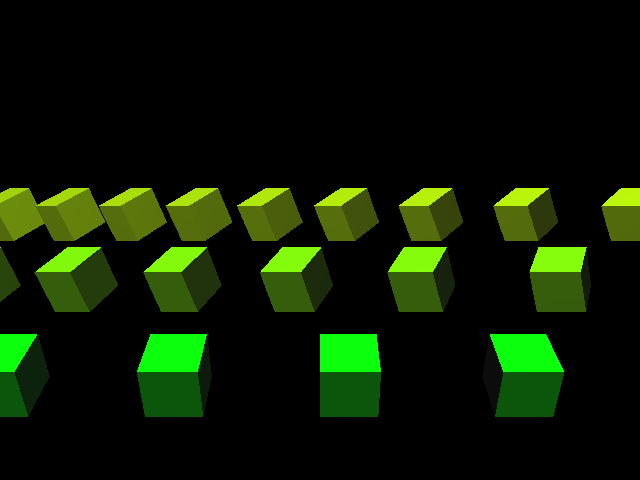

In [9]:
x,y = 5,3
f0=Frame([0,0,0])

cam = Camera(0,(0,800,-800),(0,-np.pi/6),20,f0,2)

frames = [Frame(np.array((8.0,0,0))*(1-1/(1<<i))) for i in range(y)]
boxes = [MeshObject(np.array(((i-4*j)*300,0,j*300)),frames[j],mesh.Mesh.from_file('models/block100.stl'),np.array((1-1/(1<<j),1,0))) for i in range(-x,x+1) for j in range(y)]
#floor = SphereObject(np.array((0,-90100,0)),f0,np.array((0,0,.5)),90000)

print("scene created")

scene = Scene(cam, np.array((400, 10000, -3000)), boxes)#,floor])
display(scene.render())

# Results
Some proofs of concept and cool renders we liked.